## Importing Libraries

In [40]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [45]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import itertools
from copy import deepcopy

## Loading Dataset

In [ ]:
# ImageNet normalization values
mean_img_net = np.array([0.485, 0.456, 0.406])
std_img_net = np.array([0.229, 0.224, 0.225])

#pre-processing the image data set
image_transforms=transforms.Compose([
    transforms.Resize((128, 128)),                              # 128x128 pixels in each image 
    #transforms.RandomHorizontalFlip(0.2),                       # randomly flip 20% of images horizontally for better generalization
    #transforms.RandomRotation(10),                              # randomly rotate images within 10 degrees for better generalization
    transforms.ToTensor(),                                      # Convert images to PyTorch tensors
    transforms.Normalize(mean=mean_img_net, std=std_img_net)    # Normalize to range [-1, 1]
])

In [3]:
data = datasets.ImageFolder(root= ".\dataset",transform= image_transforms)

In [4]:
len(data)

6862

In [ ]:
classes = data.classes
classes

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

In [ ]:
num_classes = len(classes)
num_classes

11

The dataset consists of 6862 images with 11 different classes.

## Visualizing the dataset

In [7]:
#denomalizing the images for visualization
def denormalize(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert [C, H, W] -> [H, W, C]
    img = std_img_net * img + mean_img_net     # Denormalize
    img = np.clip(img, 0, 1)                   # Clip to [0,1] for display
    return img

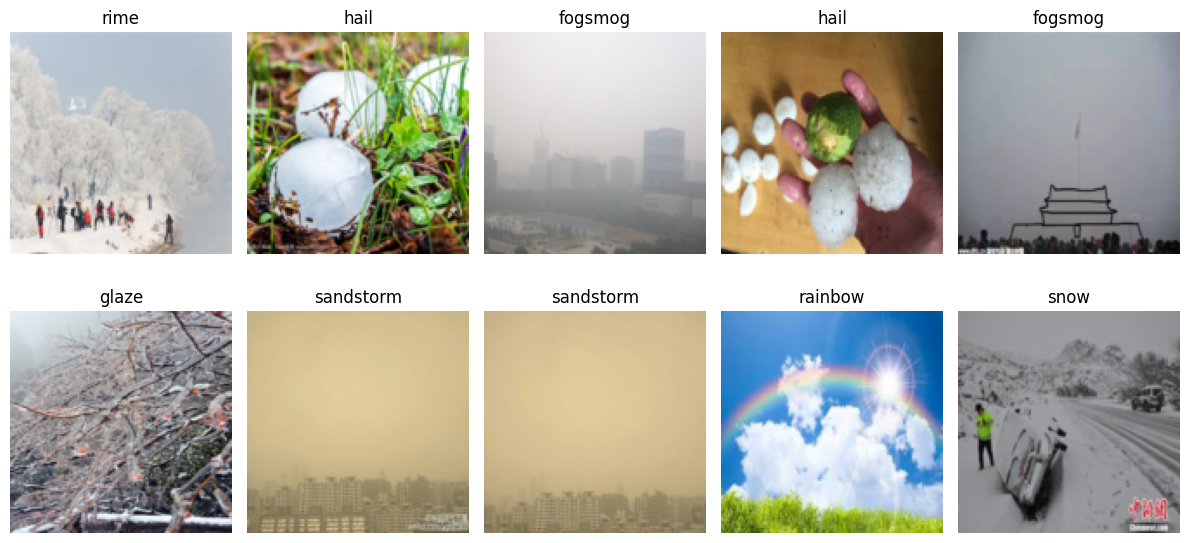

In [ ]:
# Full dataset (ImageFolder)
num_images = 10
ncols = 5
nrows = int(np.ceil(num_images / ncols))

random_sampled_indices = np.random.randint(0, len(data) - 1, num_images)

plt.figure(figsize=(12, 3 * nrows))
for i in range(num_images):
    image, label = data[random_sampled_indices[i]]  # Get image and label from the tensor
    img = denormalize(image)

    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(img)
    plt.title(classes[label])
    plt.axis("off")

plt.tight_layout()

## Splitting into train and test 

In [9]:
train_size = int(0.8 * len(data))  # 80% for training
test_size = len(data) - train_size  # 20% for testing
train_data, test_data = random_split(data, [train_size, test_size])

In [10]:
len(train_data), len(test_data)

(5489, 1373)

In [11]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [12]:
for i,(image,label) in enumerate(train_loader):
    print(image.shape)
    break

torch.Size([32, 3, 128, 128])


Each image tensor has size 128x128 with 3 channels (RGB channels). Here 32 indicates the default batch size.

## CNN with 1 Convolutional layer

We will use the following structure:

$$
    \text{Conv}\rightarrow\text{MaxPool}\rightarrow\text{Linear}\rightarrow\text{Output Layer}
$$

### Building CNN

In [ ]:
# CNN with 1 convolutional layer
class CNN_1(nn.Module):
    def __init__(self, num_classes):
        super(CNN_1, self).__init__()
        
        # Input assumed to be [B, 3, 128, 128]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)        
        self.pool = nn.MaxPool2d(kernel_size=2)
        #self.dropout1 = nn.Dropout(0.4)

        # Output size after conv & pool depends on input size. For 128×128 input:
        # Conv1: 128 → 128
        # Pool: 128 → 64
        self.flattened_size = 32 * 64 * 64

        self.fc1 = nn.Linear(self.flattened_size, 100)
        self.dropout2 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # [B, 32, 128, 128]
        x = self.pool(x)            # [B, 32, 64, 64]
        #x = self.dropout1(x)

        x = x.view(x.size(0), -1)   # Flatten → [B, 32×64×64]
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x                    # Raw logits; apply softmax during loss eval if needed

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN_1(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Linear-3                  [-1, 100]      13,107,300
           Dropout-4                  [-1, 100]               0
            Linear-5                   [-1, 11]           1,111
Total params: 13,109,307
Trainable params: 13,109,307
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 5.00
Params size (MB): 50.01
Estimated Total Size (MB): 55.20
----------------------------------------------------------------


### Training CNN

In [38]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {acc:.2f}%")


Epoch 1: Loss = 440.2186, Accuracy = 32.06%
Epoch 2: Loss = 305.4286, Accuracy = 38.91%
Epoch 3: Loss = 276.8996, Accuracy = 42.65%
Epoch 4: Loss = 259.1064, Accuracy = 45.22%
Epoch 5: Loss = 241.6829, Accuracy = 47.88%
Epoch 6: Loss = 233.9240, Accuracy = 49.23%
Epoch 7: Loss = 221.3964, Accuracy = 50.70%
Epoch 8: Loss = 210.6023, Accuracy = 52.98%
Epoch 9: Loss = 206.5726, Accuracy = 53.45%
Epoch 10: Loss = 195.6509, Accuracy = 55.31%


### Predicting using trained CNN

In [39]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 64.24%


Here, the train accuracy is less than test accuracy and the accuracy scores suggests that the CNN is underfitting. Let us add one more convolutional layer to increasse the accuracy.

## CNN with 2 Convolutional Layer

We will use the following structure:

$$
    \text{Conv}\rightarrow\text{Conv}\rightarrow\text{MaxPool}\rightarrow\text{Linear}\rightarrow\text{Output Layer}
$$

### Building CNN

In [ ]:
#CNN with 2 convolutional layer
class CNN_2(nn.Module):
    def __init__(self, num_classes):
        super(CNN_2, self).__init__()
        
        # Input assumed to be [B, 3, 128, 128]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        #self.dropout1 = nn.Dropout(0.4)

        # Output size after conv & pool depends on input size. For 128×128 input:
        # Conv1: 128 → 128
        # Conv2: 128 → 128
        # Pool: 128 → 64
        self.flattened_size = 32 * 64 * 64

        self.fc1 = nn.Linear(self.flattened_size, 100)
        self.dropout2 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # [B, 32, 128, 128]
        x = F.relu(self.conv2(x))   # [B, 32, 128, 128]
        x = self.pool(x)            # [B, 32, 64, 64]
        #x = self.dropout1(x)

        x = x.view(x.size(0), -1)   # Flatten → [B, 32×64×64]
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x                    # Raw logits; apply softmax during loss eval if needed


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN_2(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
            Conv2d-2         [-1, 32, 128, 128]           9,248
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Linear-4                  [-1, 100]      13,107,300
           Dropout-5                  [-1, 100]               0
            Linear-6                   [-1, 11]           1,111
Total params: 13,118,555
Trainable params: 13,118,555
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 9.00
Params size (MB): 50.04
Estimated Total Size (MB): 59.23
----------------------------------------------------------------


### Training CNN

In [31]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {acc:.2f}%")


Epoch 1: Loss = 290.4064, Accuracy = 47.60%
Epoch 2: Loss = 189.3711, Accuracy = 63.38%
Epoch 3: Loss = 143.3470, Accuracy = 73.02%
Epoch 4: Loss = 93.7121, Accuracy = 82.16%
Epoch 5: Loss = 65.1149, Accuracy = 87.54%
Epoch 6: Loss = 44.5769, Accuracy = 91.49%
Epoch 7: Loss = 36.9547, Accuracy = 92.86%
Epoch 8: Loss = 31.5643, Accuracy = 93.92%
Epoch 9: Loss = 25.3659, Accuracy = 95.01%
Epoch 10: Loss = 22.2889, Accuracy = 95.54%


### Predicting using trained CNN

In [32]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 71.01%


This CNN with 2 convolutional layers has training accuracy significantly larger than its test accuracy, suggesting that the CNN is overfitting the training data. Let us now regularize the model using hyperparameter tuning. 

## Regularizing CNN using hyperparameter tuning

### Building CNN with hyeperparameters

In [47]:
class CNN(nn.Module):
    def __init__(self, num_classes, conv1_out, conv2_out, dropout1, dropout2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, conv1_out, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(dropout1)

        self.flattened_size = conv2_out * 64 * 64
        self.fc1 = nn.Linear(self.flattened_size, 100)
        self.dropout2 = nn.Dropout(dropout2)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.fc2(x)

### Defining parameter grid and tuning CNN

In [48]:
dropout1_vals = [0.3, 0.4]
dropout2_vals = [0.4]
conv1_out_vals = [32]
conv2_out_vals = [32]
lr_vals = [1e-3]

param_grid = list(itertools.product(dropout1_vals, dropout2_vals, conv1_out_vals, conv2_out_vals, lr_vals))

In [49]:
num_epochs = 5
batch_size = 32
best_val_acc = 0
best_config = None

for i, (drop1, drop2, conv1_out, conv2_out, lr) in enumerate(param_grid):
    print(f"\n Testing config {i+1}/{len(param_grid)}:")
    print(f"Dropout1={drop1}, Dropout2={drop2}, Conv1={conv1_out}, Conv2={conv2_out}, LR={lr}")

    # Split dataset into training and validation (every time)
    train_size = int(0.8 * len(train_data))
    val_size = len(train_data) - train_size
    train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = CNN(num_classes, conv1_out, conv2_out, drop1, drop2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation loop
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    print(f"Validation Accuracy: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = (drop1, drop2, conv1_out, conv2_out, lr)
        best_model = deepcopy(model)


 Testing config 1/2:
Dropout1=0.3, Dropout2=0.4, Conv1=32, Conv2=32, LR=0.001
Validation Accuracy: 70.49%

 Testing config 2/2:
Dropout1=0.4, Dropout2=0.4, Conv1=32, Conv2=32, LR=0.001
Validation Accuracy: 69.67%


### Best parameters

In [51]:
best_dropout1 = best_config[0]
best_dropout2 = best_config[1]
best_conv1_out = best_config[2]
best_conv2_out = best_config[3]
best_lr = best_config[4]

print("\n Best Config:")
print(f"Dropout1={best_dropout1}, Dropout2={best_dropout2}, Conv1={best_conv1_out}, Conv2={best_conv2_out}, LR={best_lr}")
print(f"Validation Accuracy: {best_val_acc:.2f}%")


 Best Config:
Dropout1=0.3, Dropout2=0.4, Conv1=32, Conv2=32, LR=0.001
Validation Accuracy: 70.49%


### Training Best CNN

In [52]:
model = CNN(num_classes, best_conv1_out, best_conv2_out, best_dropout1, best_dropout2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
            Conv2d-2         [-1, 32, 128, 128]           9,248
         MaxPool2d-3           [-1, 32, 64, 64]               0
           Dropout-4           [-1, 32, 64, 64]               0
            Linear-5                  [-1, 100]      13,107,300
           Dropout-6                  [-1, 100]               0
            Linear-7                   [-1, 11]           1,111
Total params: 13,118,555
Trainable params: 13,118,555
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 10.00
Params size (MB): 50.04
Estimated Total Size (MB): 60.23
----------------------------------------------------------------


In [53]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {acc:.2f}%")

Epoch 1: Loss = 273.8737, Accuracy = 39.17%
Epoch 2: Loss = 167.4874, Accuracy = 61.69%
Epoch 3: Loss = 123.2096, Accuracy = 70.99%
Epoch 4: Loss = 89.3328, Accuracy = 79.50%
Epoch 5: Loss = 64.6573, Accuracy = 85.04%
Epoch 6: Loss = 48.7302, Accuracy = 88.52%
Epoch 7: Loss = 39.5828, Accuracy = 90.32%
Epoch 8: Loss = 31.1225, Accuracy = 92.51%
Epoch 9: Loss = 26.8561, Accuracy = 93.35%
Epoch 10: Loss = 25.8151, Accuracy = 93.67%


### Predicting using trained CNN

In [54]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 66.13%
